# Projet 7 - Effectuez une prédiction de revenus

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import P7_03_OCR7 as OCR

from scipy.stats import shapiro

%matplotlib inline

sns.set(color_codes = True)

In [2]:
_FONTSIZE_ = 18
_FONTSIZETITLE_ = 24

## Préparation des données

In [3]:
df_raw = pd.read_csv('./Data/data-projet7.csv')
df_gini_raw = pd.read_csv('./Data/gini.csv')

### Changement de type des données de Object à Float

In [4]:
df_raw['income'] = df_raw['income'].replace(to_replace=r',', value=r'.', regex=True).astype(float)
df_raw['gdpppp'] = df_raw['gdpppp'].replace(to_replace=r',', value=r'.', regex=True).astype(float)

### Nettoyage ayant des valeurs manquantes 

In [5]:
df_raw[df_raw['gdpppp'].isnull()].country.value_counts()

PSE    100
XKX    100
Name: country, dtype: int64

In [6]:
df_raw['country'].value_counts()[df_raw['country'].value_counts() != 100]

LTU    99
Name: country, dtype: int64

Nous voyons que les pays 'PSE' et 'XKX' n'ont pas de gdp ppp, ainsi que le pays 'LTU' n'a pas l'ensemple de ses percentiles.

In [7]:
df = df_raw[~(df_raw['country'].isin(['XKX', 'LTU', 'PSE']))]

Nous enlevons ces pays de notre dataFrame.

### Ajout du coefficient de Gini

Dans la liste des coefficients de Gini par pays, de nombreuses valeurs sont manquantes. Concernant la variation du coefficient de Gini en fonction des années, il serait pertinent de vérifier si ces variations sont significatives

Pour se faire, nous allons regarder si les variations sont comprises entre plus ou moins deux ecart-types.

In [8]:
df_gini = pd.DataFrame(columns = ['country name', 'country', 'Year', 'Gini'])

Nous allons réorganiser ce dataframe pour l'exploiter plus facilement

In [9]:
for i in range(0, df_gini_raw.shape[0]):
    for j in range(4, df_gini_raw.shape[1]):
        if df_gini_raw.iloc[i, j] > 0:
            df_gini.loc[i*j]=[df_gini_raw.iloc[i,0], df_gini_raw.iloc[i,1], 1956+j, df_gini_raw.iloc[i, j]]

In [10]:
df_gini.reset_index().drop(columns=['index'], inplace = True)

Nous constatons que des pays n'ont aucun coefficient de Gini de calculer, ainsi, sans ces données, il n'est pas possible d'exploiter les informations de ce pays

In [11]:
df_gini_unique = pd.merge(df_gini, df_gini.groupby('country').mean(), how = 'right', on = 'country')
df_gini_unique.rename(columns={'Gini_x': 'Gini', 'Gini_y': 'Mean Gini'}, inplace=True)

In [12]:
df_gini

,country name,country,Year,Gini
88,Angola,AGO,2000,52.0
104,Angola,AGO,2008,42.7
124,Angola,AGO,2018,51.3
120,Albania,ALB,1996,27.0
138,Albania,ALB,2002,31.7
...,...,...,...,...
13100,Zambia,ZMB,2006,54.6
14148,Zambia,ZMB,2010,55.6
15458,Zambia,ZMB,2015,57.1
14465,Zimbabwe,ZWE,2011,43.2


In [13]:
df_gini_unique['Centered Gini'] = (df_gini_unique['Gini'] - df_gini_unique['Mean Gini']) / df_gini_unique['Gini'].std()

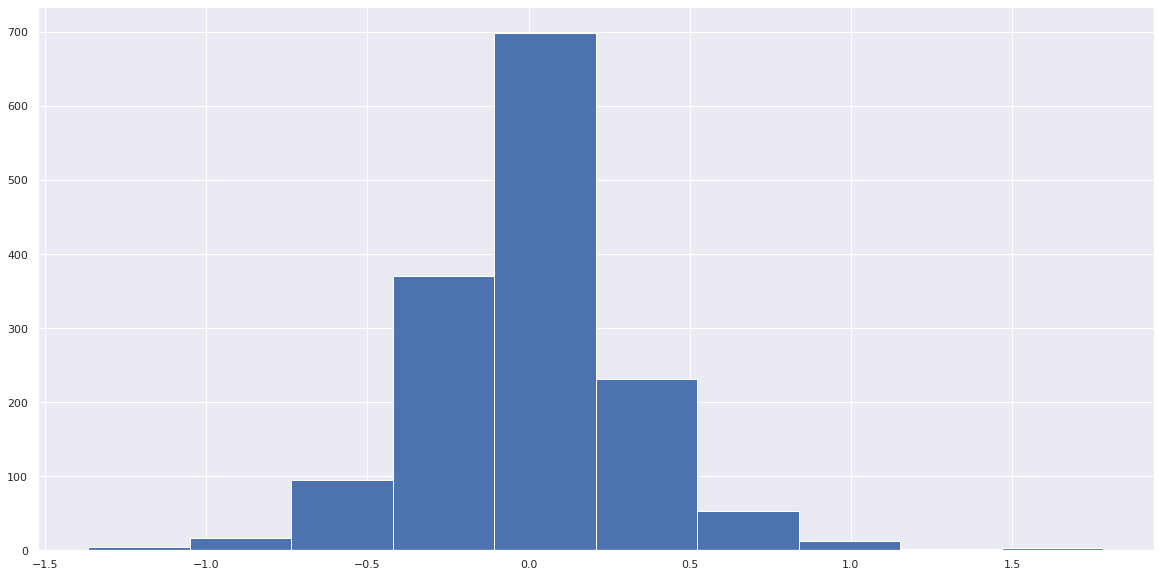

In [14]:
fig, axes = plt.subplots(figsize = (20, 10))
df_gini_unique['Centered Gini'].hist()

Nous voyons que l'écart-type pour la variation du coefficient de Gini n'est pas significative, par conséquent nous pouvons utiliser la moyenne au lieu d'une année spécifique.

In [15]:
df_gini_unique.drop_duplicates(subset=['country'], inplace = True)
df_gini_unique.drop(columns=['Year', 'Gini'], inplace = True)
df = pd.merge(df, df_gini_unique[['country name', 'Mean Gini', 'country']], how = 'right', on = 'country')

In [16]:
df = df[~(df['year_survey'].isna())]

## Mission 1 

Résumez les données utilisées :

* année(s) des données utilisées sont 2004, 2006, 2007, 2008, 2009, 2010, 2011 
* nombre de pays présents après vérification des données est de 111 pays;
* population couverte par l'analyse (en termes de pourcentage de la population mondiale).

Les données de la World Income Distribution présentent pour chaque pays les quantiles de la distribution des revenus de leur population respective :

* De quel type de quantiles s'agit-il (quartiles, déciles, etc.) ?
* Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?


In [17]:
df['year_survey'].unique()

array([2008., 2009., 2010., 2007., 2006., 2011., 2004.])

In [18]:
f"Il y a {df['country'].unique().shape[0]} pays dans le dataframe après nettoyage des données"

'Il y a 111 pays dans le dataframe après nettoyage des données'

**De quel type de quantiles s'agit-il (quartiles, déciles, etc.) ?**

Il s'agit de percentiles, c'est-à-dire de quantité représentant 1%

**Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?**

Cela permet d'avoir une granularité plus fine et une analyse plus précise pour discréminer des groupes ou des tendances.

## Mission 2


Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.
* Représentez la courbe de Lorenz de chacun des pays choisis.
* Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.
* Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?


Nous allons choisir des pays selon leur congiguration socio-économique, c'est-à-dire des pays pauvres, en voie de développement et des pays riches, des pays exportateurs nets et des pays dont l'économie se base sur l'exploitation d'une seule ressource.

Pour ce faire, nous allons choisir la Chine, un pays du golfe, un pays appartenant au BRICS, un pays riche peu peuplé et 4 pays appartenant à chaque quartile du GDP PPP.

In [19]:
df[df['gdpppp'] < df.quantile(.25)['gdpppp']].sample(n=1, random_state=1)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,country name,Mean Gini
7277,MWI,2010.0,78.0,100.0,1077.0197,728.81158,Malawi,48.975


In [20]:
df[df['gdpppp'].isin(df.quantile([.25, .5])['gdpppp'].values)].sample(n=1, random_state=2)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,country name,Mean Gini
7612,NIC,2009.0,13.0,100.0,568.1765,2576.0,Nicaragua,50.6


In [21]:
df[df['gdpppp'].isin(df.quantile([.5, .75])['gdpppp'].values)].sample(n=1, random_state=2)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,country name,Mean Gini
3012,EST,2008.0,13.0,100.0,3616.012,18773.0,Estonia,33.115385


In [22]:
df[df['gdpppp'] > df.quantile(.75)['gdpppp']].sample(n=1, random_state=1)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,country name,Mean Gini
4977,ISR,2008.0,78.0,100.0,15182.026,25740.0,Israel,39.163636


In [23]:
df[df['country name'] == 'China']

,country,year_survey,quantile,nb_quantiles,income,gdpppp,country name,Mean Gini
1700,CHN,2007.0,1.0,100.0,16.719418,5712.0,China,39.21
1701,CHN,2007.0,2.0,100.0,234.150730,5712.0,China,39.21
1702,CHN,2007.0,3.0,100.0,282.894900,5712.0,China,39.21
1703,CHN,2007.0,4.0,100.0,323.826500,5712.0,China,39.21
1704,CHN,2007.0,5.0,100.0,362.260600,5712.0,China,39.21
...,...,...,...,...,...,...,...,...
1795,CHN,2007.0,96.0,100.0,7588.195000,5712.0,China,39.21
1796,CHN,2007.0,97.0,100.0,8317.553000,5712.0,China,39.21
1797,CHN,2007.0,98.0,100.0,9382.284000,5712.0,China,39.21
1798,CHN,2007.0,99.0,100.0,11071.510000,5712.0,China,39.21


In [24]:
df[df['country name'] == 'Brazil']

,country,year_survey,quantile,nb_quantiles,income,gdpppp,country name,Mean Gini
1200,BRA,2008.0,1.0,100.0,144.02846,9559.0,Brazil,56.933333
1201,BRA,2008.0,2.0,100.0,245.92259,9559.0,Brazil,56.933333
1202,BRA,2008.0,3.0,100.0,347.86597,9559.0,Brazil,56.933333
1203,BRA,2008.0,4.0,100.0,430.76090,9559.0,Brazil,56.933333
1204,BRA,2008.0,5.0,100.0,506.10590,9559.0,Brazil,56.933333
...,...,...,...,...,...,...,...,...
1295,BRA,2008.0,96.0,100.0,16323.82100,9559.0,Brazil,56.933333
1296,BRA,2008.0,97.0,100.0,18917.69100,9559.0,Brazil,56.933333
1297,BRA,2008.0,98.0,100.0,22820.66800,9559.0,Brazil,56.933333
1298,BRA,2008.0,99.0,100.0,29642.62000,9559.0,Brazil,56.933333


In [25]:
df[df['country name'].str.contains('Iran')]

,country,year_survey,quantile,nb_quantiles,income,gdpppp,country name,Mean Gini
4600,IRN,2008.0,1.0,100.0,441.56308,10446.0,"Iran, Islamic Rep.",43.133333
4601,IRN,2008.0,2.0,100.0,701.21075,10446.0,"Iran, Islamic Rep.",43.133333
4602,IRN,2008.0,3.0,100.0,854.72504,10446.0,"Iran, Islamic Rep.",43.133333
4603,IRN,2008.0,4.0,100.0,969.65260,10446.0,"Iran, Islamic Rep.",43.133333
4604,IRN,2008.0,5.0,100.0,1067.15340,10446.0,"Iran, Islamic Rep.",43.133333
...,...,...,...,...,...,...,...,...
4695,IRN,2008.0,96.0,100.0,15637.79700,10446.0,"Iran, Islamic Rep.",43.133333
4696,IRN,2008.0,97.0,100.0,17546.96000,10446.0,"Iran, Islamic Rep.",43.133333
4697,IRN,2008.0,98.0,100.0,20007.95900,10446.0,"Iran, Islamic Rep.",43.133333
4698,IRN,2008.0,99.0,100.0,24767.04000,10446.0,"Iran, Islamic Rep.",43.133333


In [26]:
df[df['country name'] == 'Luxembourg']

,country,year_survey,quantile,nb_quantiles,income,gdpppp,country name,Mean Gini
6000,LUX,2008.0,1.0,100.0,5780.8374,73127.0,Luxembourg,30.99
6001,LUX,2008.0,2.0,100.0,7315.2686,73127.0,Luxembourg,30.99
6002,LUX,2008.0,3.0,100.0,7891.2456,73127.0,Luxembourg,30.99
6003,LUX,2008.0,4.0,100.0,8312.0310,73127.0,Luxembourg,30.99
6004,LUX,2008.0,5.0,100.0,8945.6380,73127.0,Luxembourg,30.99
...,...,...,...,...,...,...,...,...
6095,LUX,2008.0,96.0,100.0,53724.6300,73127.0,Luxembourg,30.99
6096,LUX,2008.0,97.0,100.0,58382.3120,73127.0,Luxembourg,30.99
6097,LUX,2008.0,98.0,100.0,65280.2200,73127.0,Luxembourg,30.99
6098,LUX,2008.0,99.0,100.0,77673.3700,73127.0,Luxembourg,30.99


Nous avons 8 pays, la Chine, le Brasil, l'Irank, le Malawi, le Nicaragua, l'Estonie, Israël et le Luxembourg

In [27]:
pays = ['Malawi', 'Nicaragua', 'Estonia', 'Israel', 'China', 'Brazil', 'Iran, Islamic Rep.', 'Luxembourg']

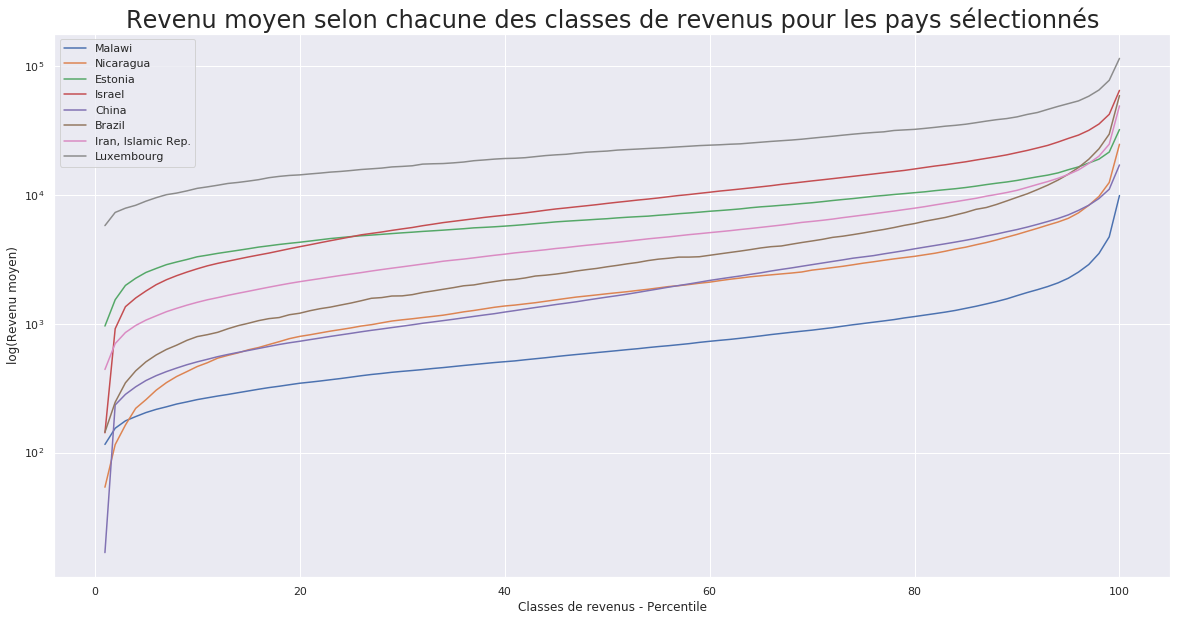

In [28]:
fig, axes = plt.subplots(1, 1, figsize = (20, 10))

for p in pays:
    plt.plot(df[df['country name'] == p]['quantile'], df[df['country name'] == p].income, label = p)

plt.xlabel('Classes de revenus - Percentile')
plt.ylabel('log(Revenu moyen)')
plt.yscale('log')
plt.title('Revenu moyen selon chacune des classes de revenus pour les pays sélectionnés', fontsize=_FONTSIZETITLE_)
plt.legend(loc='upper left')
plt.show()

### Représentez la courbe de Lorenz de chacun des pays choisis.

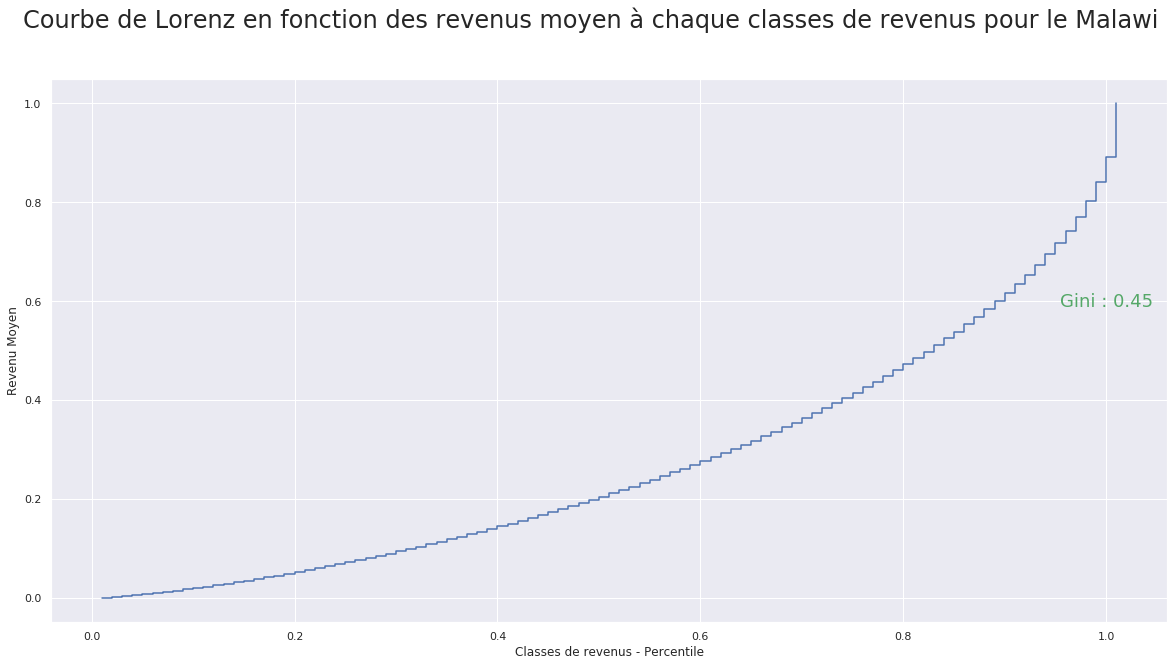

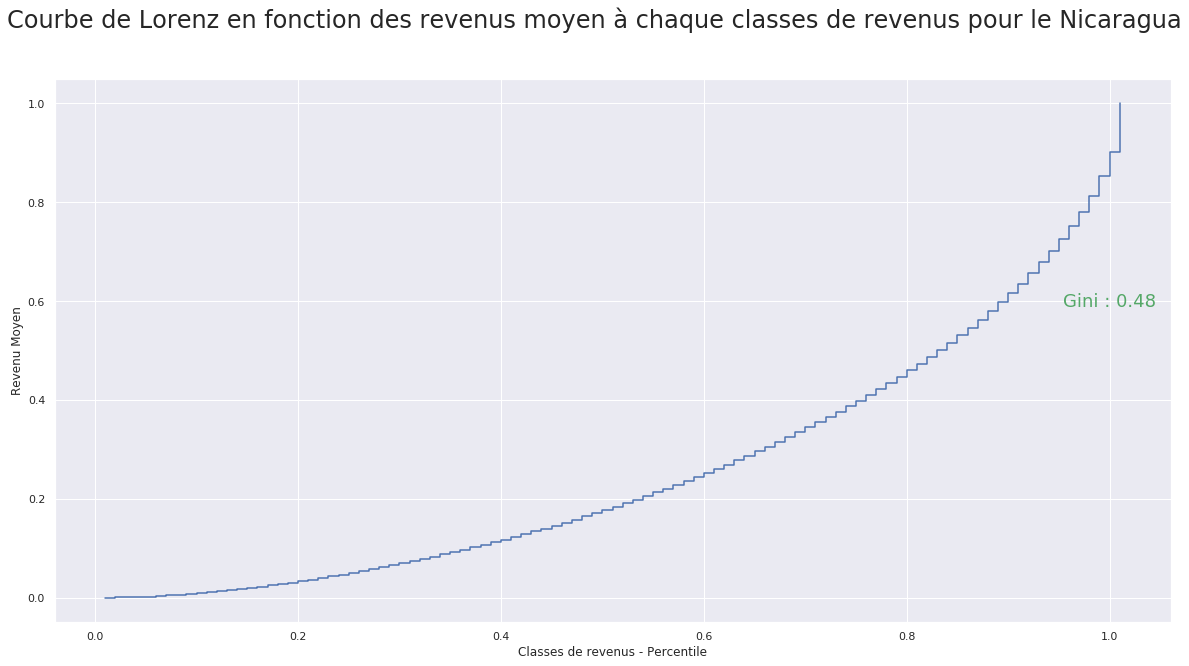

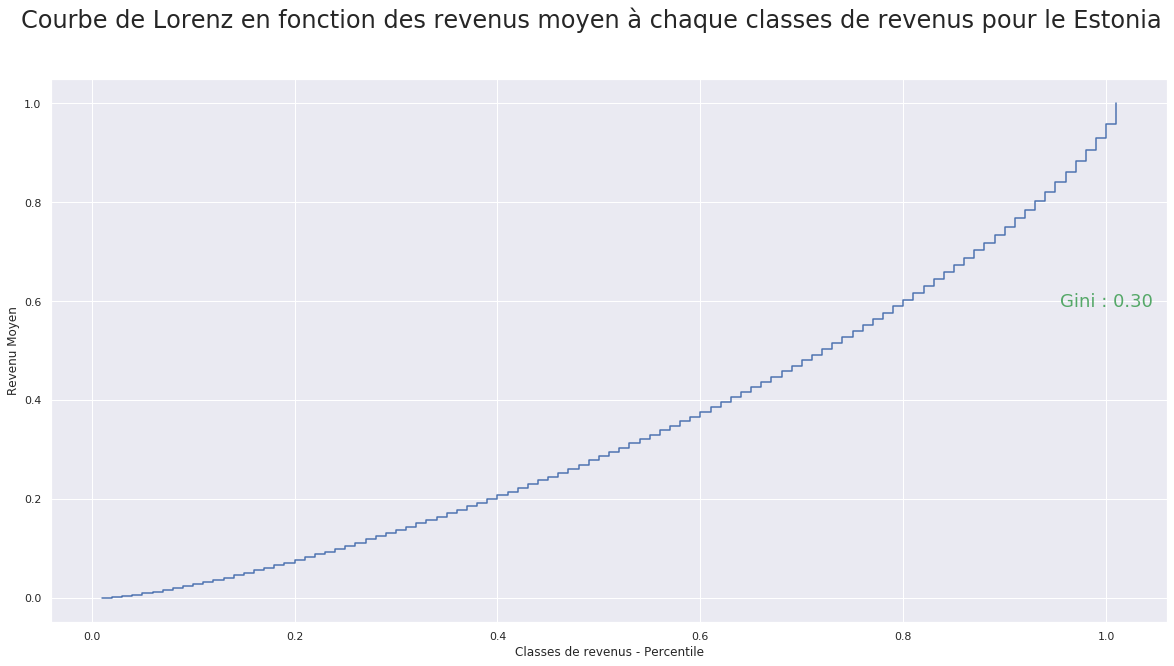

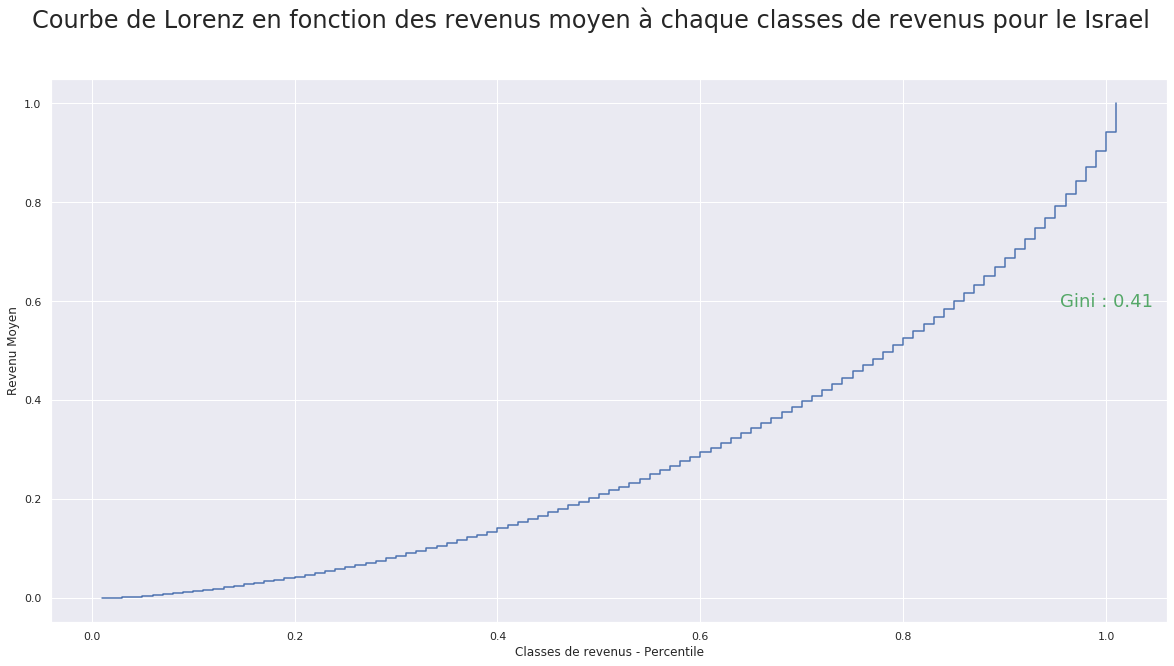

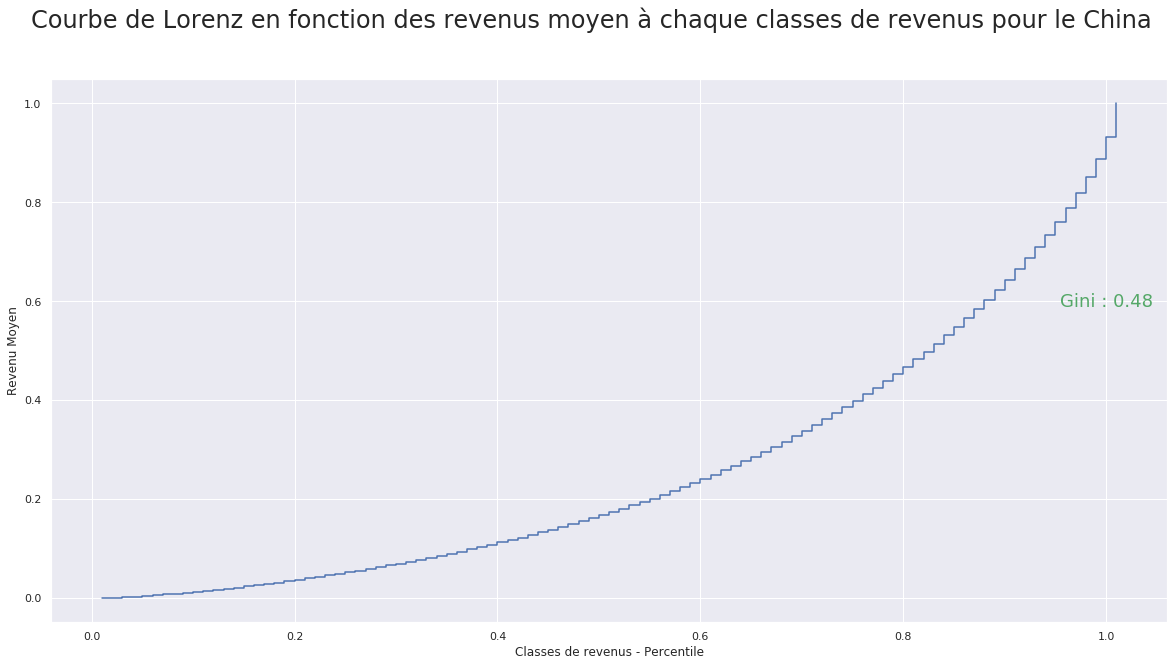

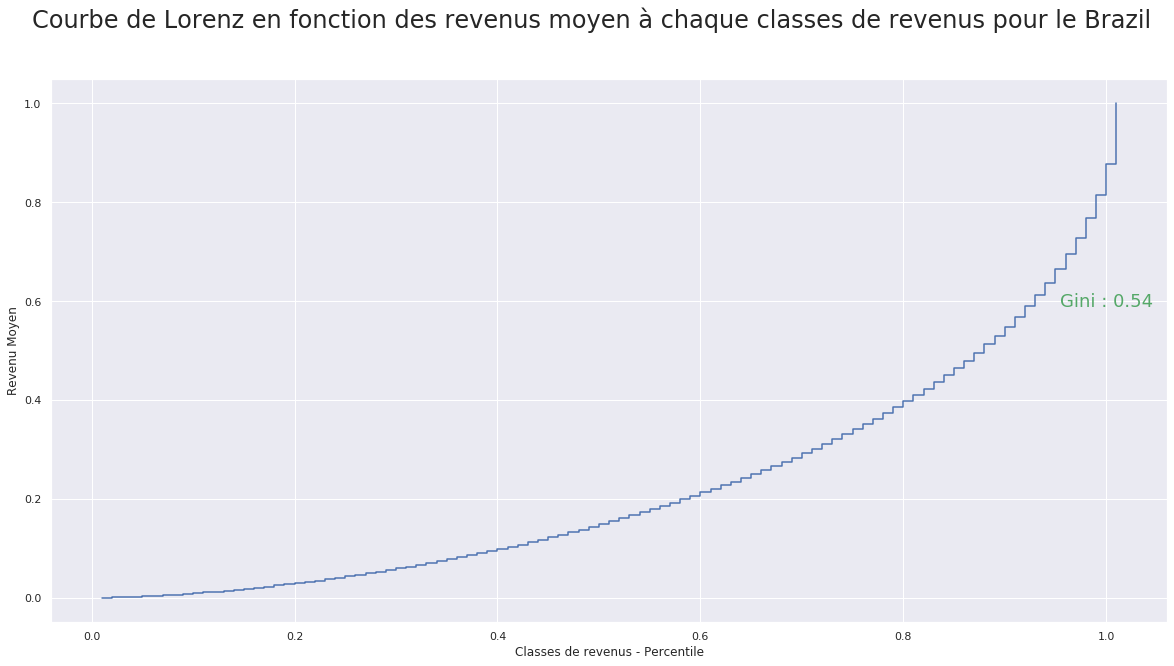

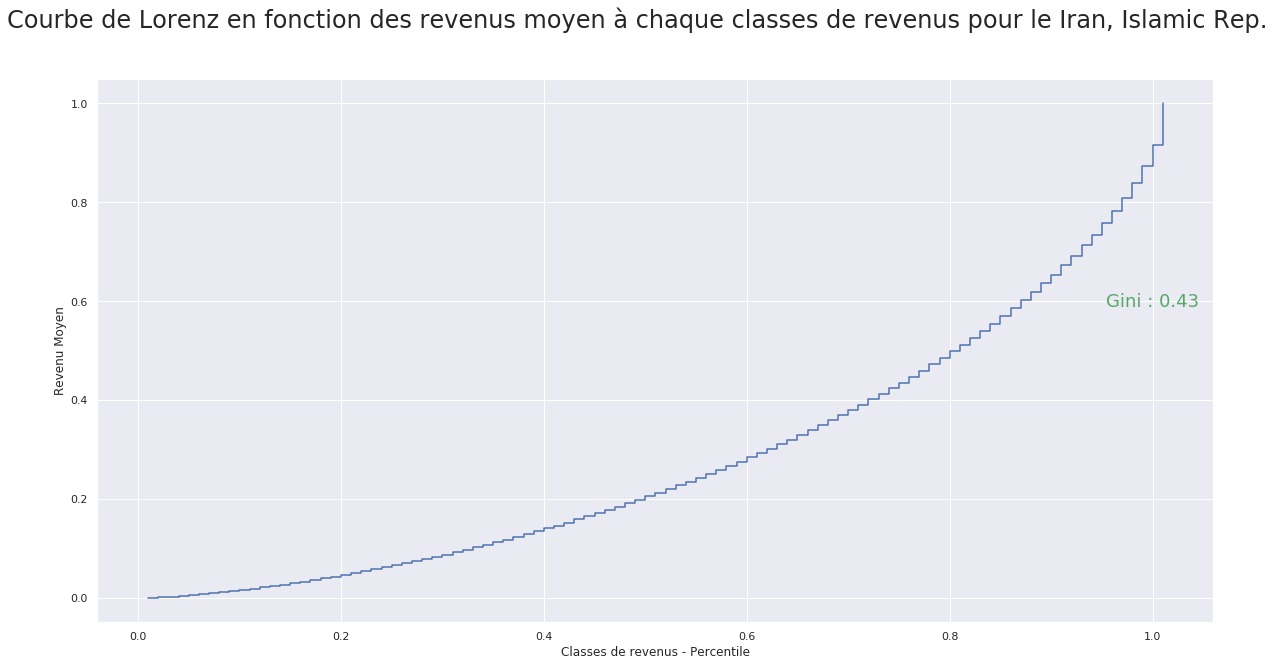

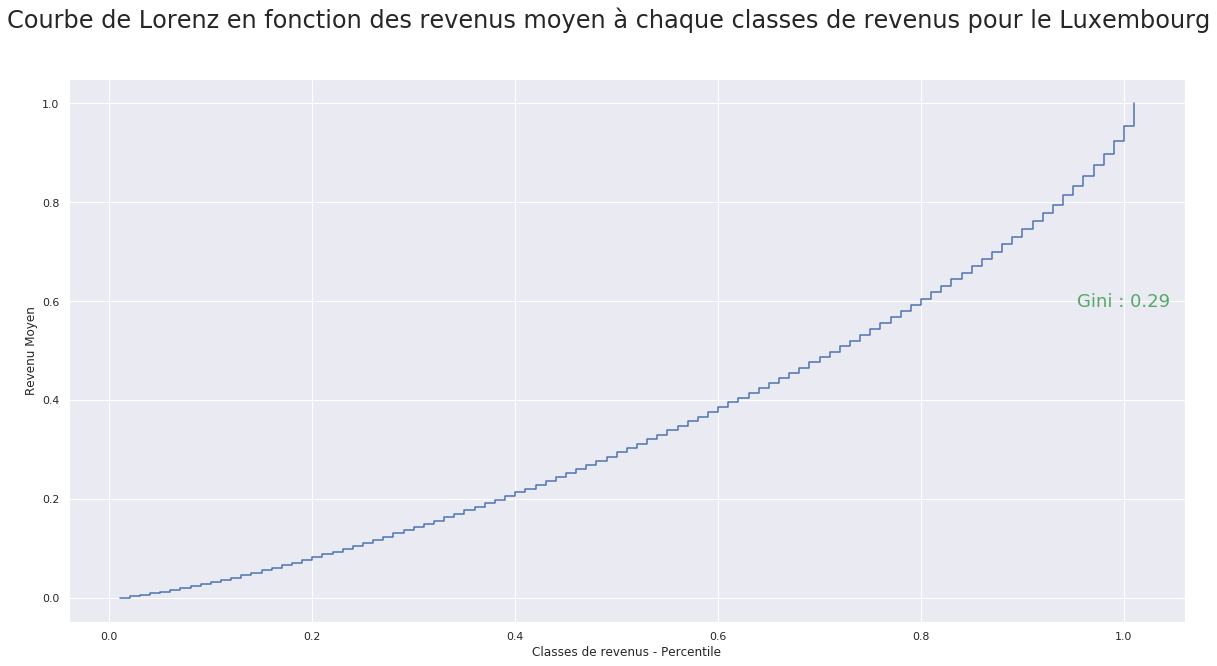

In [29]:
for p in pays:
    fig, axes = plt.subplots(1, 1, figsize=(20, 10))
    fig.suptitle(f"Courbe de Lorenz en fonction des revenus moyen à chaque classes de revenus pour le {p}", fontsize= _FONTSIZETITLE_)
    
    axes.set_xlabel('Classes de revenus - Percentile')
    axes.set_ylabel('Revenu Moyen')
    
    lorenz, n, gini = OCR.lorenz(pd.DataFrame(data=df[df['country name'] == p]['income']))

    xaxis = np.linspace(1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.

    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    plt.text(1, 0.6, f"Gini : {gini:0.2f}", {'color': 'C2', 'fontsize': 18}, va="center", ha="center")

    plt.show()

### Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.

Malawi


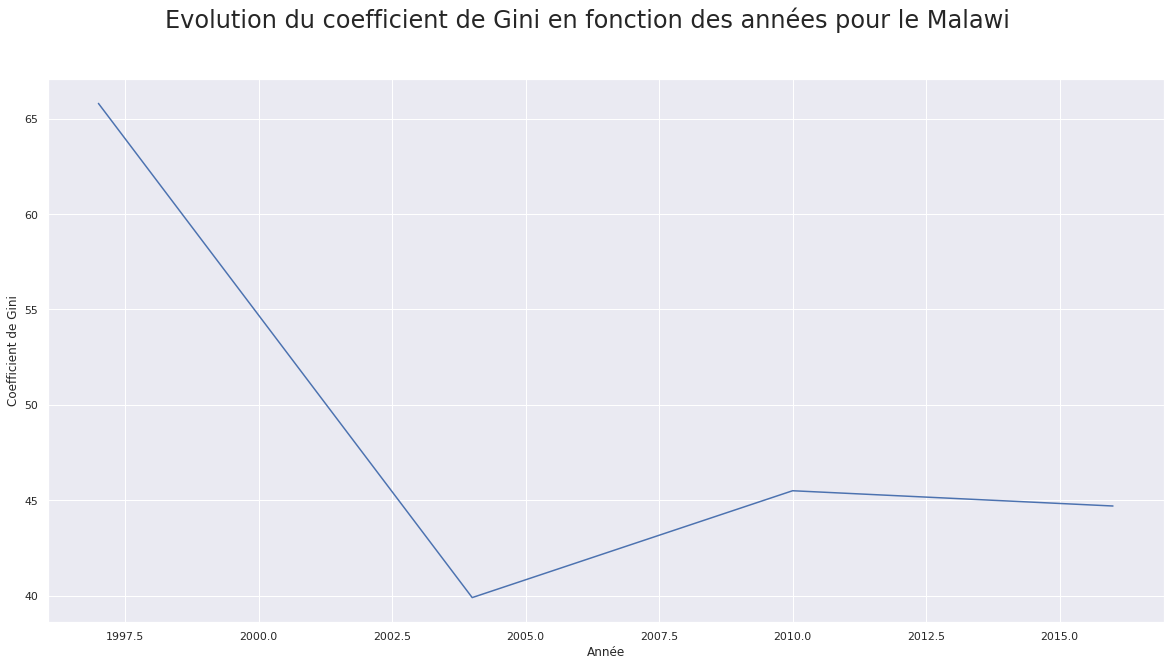

Nicaragua


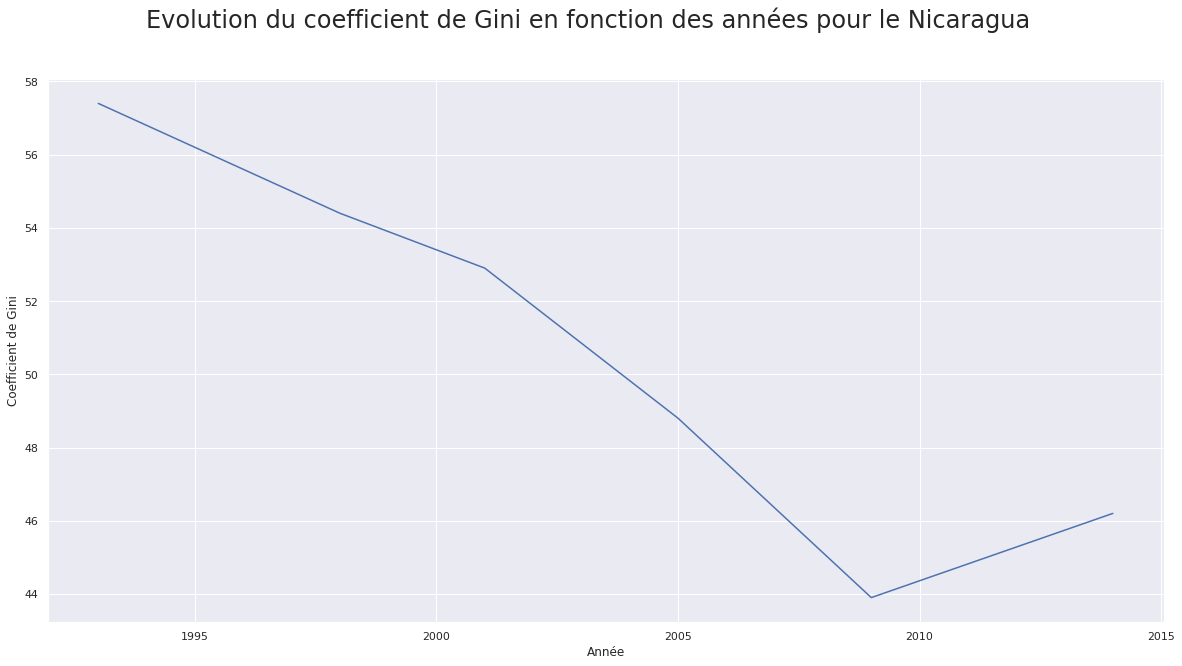

Estonia


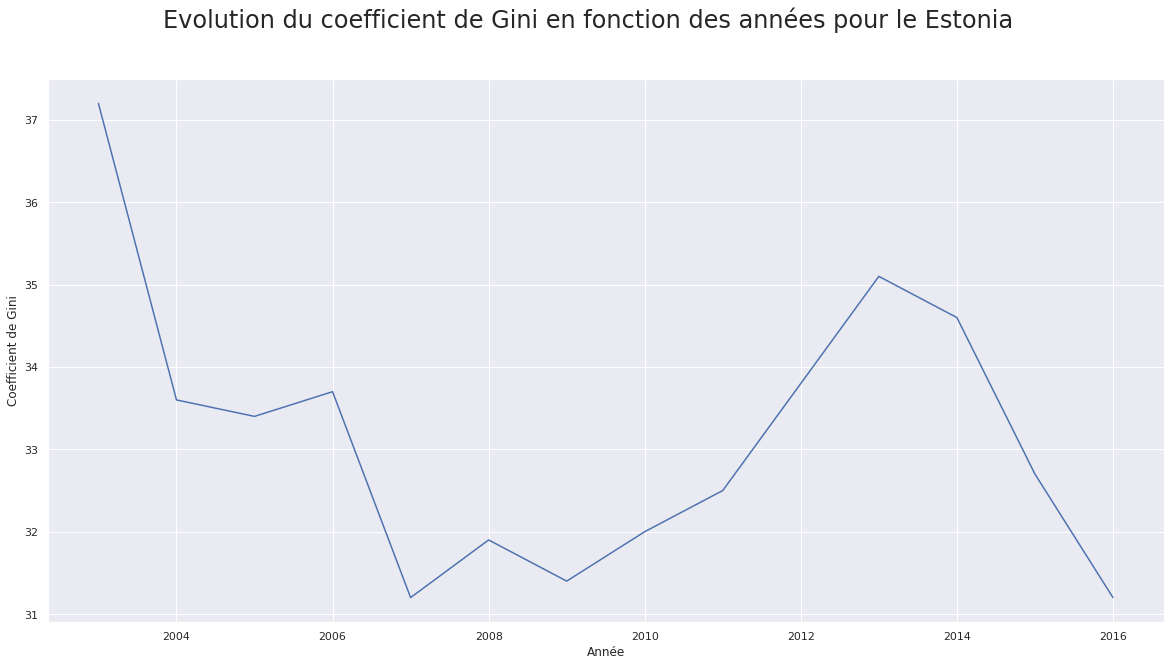

Israel


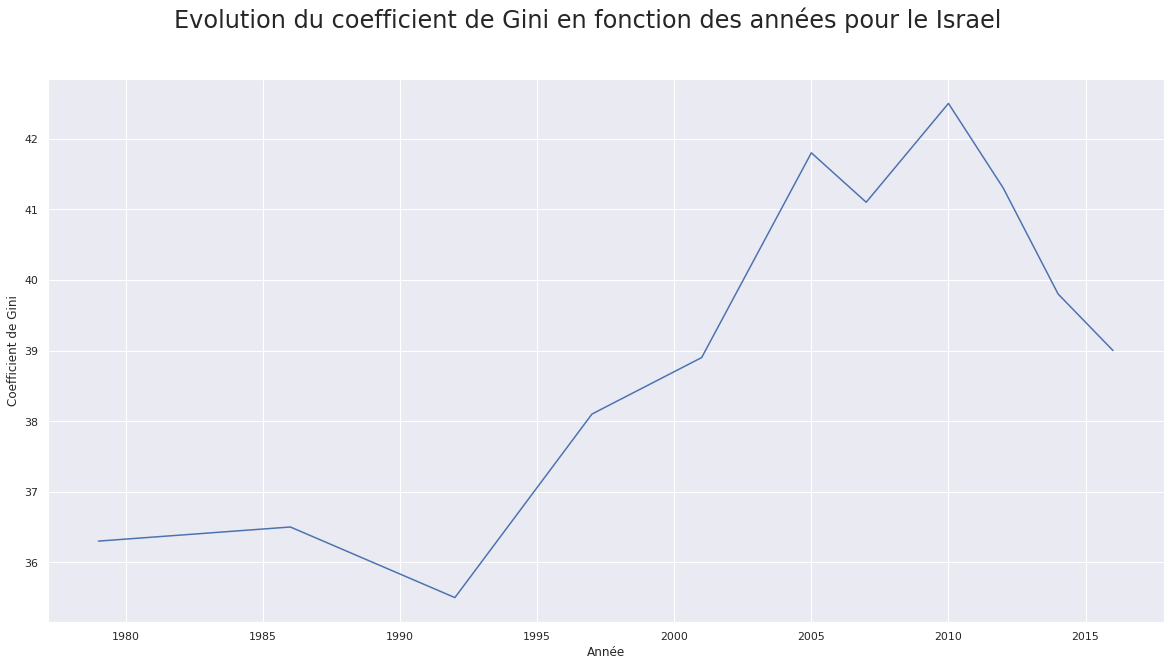

China


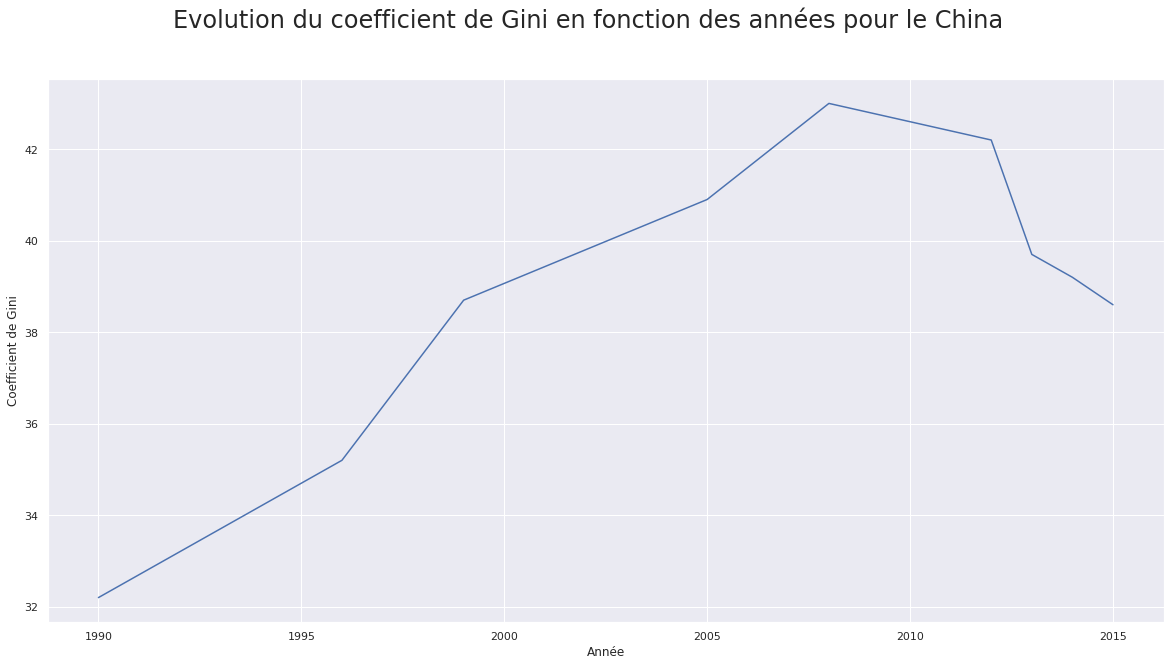

Brazil


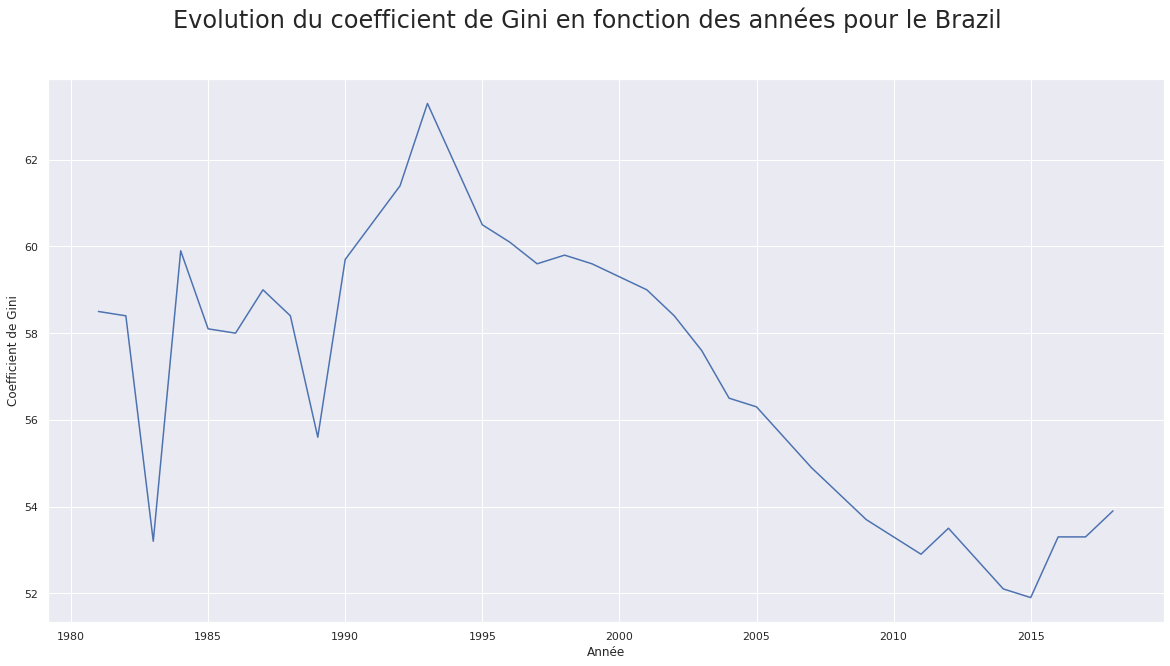

Iran, Islamic Rep.


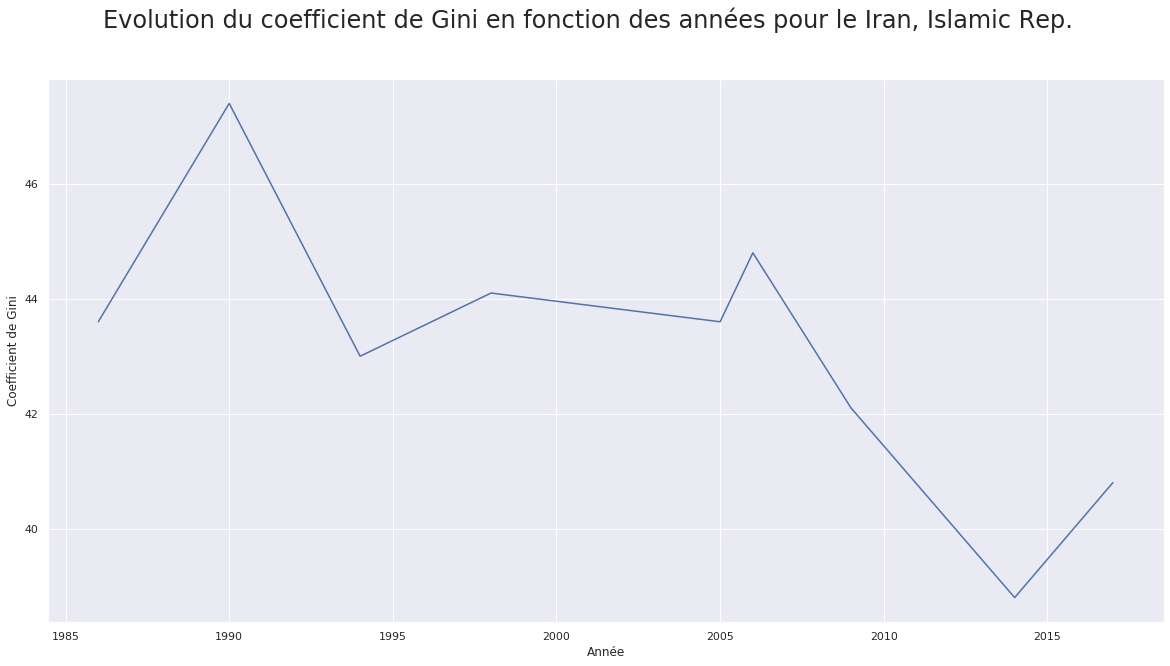

Luxembourg


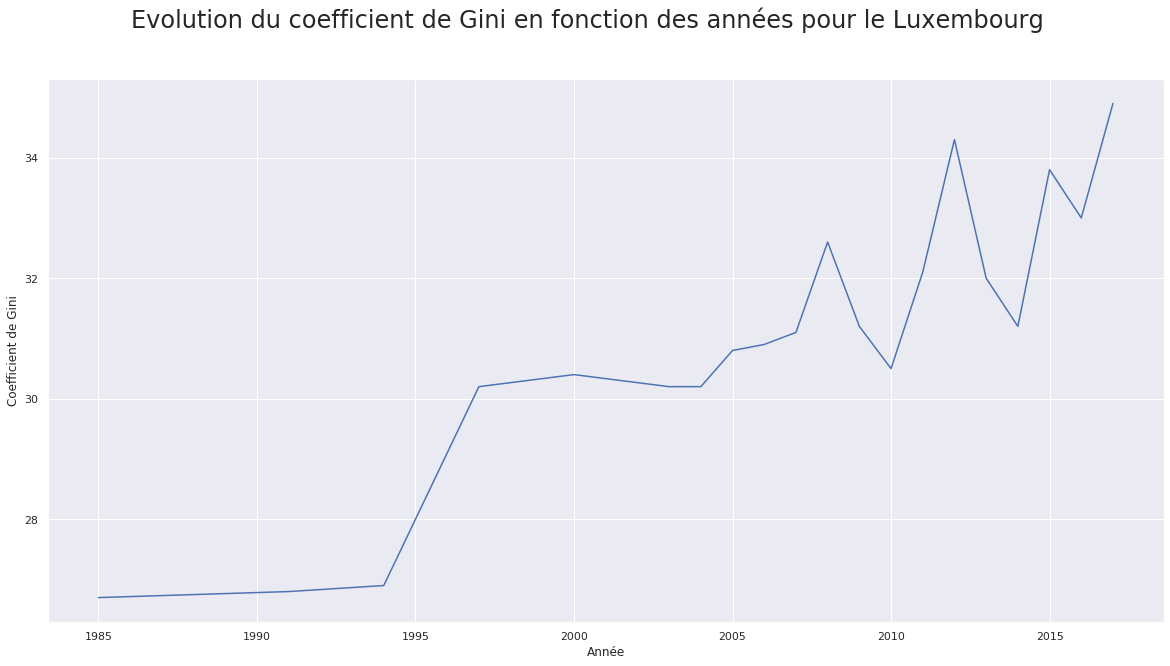

In [32]:
for p in pays:
    fig, axes = plt.subplots(1, 1, figsize=(20, 10))
    fig.suptitle(f"Evolution du coefficient de Gini en fonction des années pour le {p}", fontsize= _FONTSIZETITLE_)
    
    axes.set_xlabel('Année')
    axes.set_ylabel('Coefficient de Gini')
    
    print(p)
    
    plt.plot(df_gini.sort_values(by=['Year'])[df_gini.sort_values(by=['Year'])['country name'] == p]['Year'].astype(int), df_gini[df_gini['country name'] == p]['Gini'])

    plt.show()

### Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?

#### Les 5 pays ayant l'indice de Gini le plus élevé

In [45]:
df_gini_unique.sort_values(by=['Mean Gini']).reset_index().tail()

,level_0,index,country name,country,Mean Gini,Centered Gini
159,142,1351,Suriname,SUR,57.600000,0.000000
160,21,251,Belize,BLZ,57.733333,0.271801
161,20,247,Botswana,BWA,58.175000,0.690974
162,114,1125,Namibia,NAM,61.133333,0.229442
163,117,1140,South Africa,ZAF,61.714286,-0.107409


#### Les 5 pays ayant l'indice de Gini le plus faible

In [46]:
df_gini_unique.sort_values(by=['Mean Gini']).reset_index().head()

,level_0,index,country name,country,Mean Gini,Centered Gini
0,129,1256,Slovenia,SVN,24.990909,-0.020217
1,37,395,Czech Republic,CZE,25.907692,0.073313
2,41,436,Denmark,DNK,26.133333,0.007060
3,143,1352,Slovak Republic,SVK,26.607692,0.052134
4,118,1147,Norway,NOR,26.688235,0.022425


#### La position de la France

In [57]:
f"La France se trouve en {df_gini_unique.sort_values(by=['Mean Gini']).reset_index()[df_gini_unique.sort_values(by=['Mean Gini']).reset_index()['country name'] == 'France'].index[0] + 1}e position"

'La France se trouve en 36e position'

## Mission 3

* Générez un grand nombre  de réalisations d'une variable que nous appellerons ln(Yparent) selon une loi normale. Le choix de la moyenne et de l'écart-type n'auront pas d'incidence sur le résultat final. _n_ doit être supérieur à 1000 fois le nombre de quantiles.

## Mission 4